# Rt Live Model

In [1]:
%load_ext autoreload
%autoreload 2

import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from matplotlib import pyplot as plt
from covid.models.generative import GenerativeModel
from covid.data import summarize_inference_data
%config InlineBackend.figure_format = 'retina'

from covid.data import get_and_process_covidtracking_data_il, get_and_process_covidtracking_data_ilsev, summarize_inference_data

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-9ai3bfbl because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Fetch data and select the state's data

In [2]:
df = get_and_process_covidtracking_data_il(run_date=pd.Timestamp.today())#-pd.Timedelta(days=1))
dfunn = get_and_process_covidtracking_data_il(run_date=pd.Timestamp.today(), norm=False)#-pd.Timedelta(days=1))
dfsev = get_and_process_covidtracking_data_ilsev(run_date=pd.Timestamp.today()-pd.Timedelta(days=1))

In [3]:
region = "Israel"
model_data = df.loc[region]
model_sev = dfsev.loc[region]
model_sev_dash = dfunn.loc[region]
model_sev_dash['positive'] = model_sev_dash['severe']
model_unn = dfunn.loc[region]

## Create the model instance and sample

In [4]:
gmsev = GenerativeModel(region, model_sev, buffer_days = 20, delay=2+5, sigma=0.07)
gmsev.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 1683 seconds.


In [5]:
gmsevdash = GenerativeModel(region, model_sev_dash, buffer_days = 20, delay=2+5, sigma=0.07)
gmsevdash.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 2453 seconds.


In [6]:
gmunn = GenerativeModel(region, model_unn, delay=2, sigma=0.07)
gmunn.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 1704 seconds.


## Summarize Model Output

In [7]:
resultsev = summarize_inference_data(gmsev.inference_data)
resultunn = summarize_inference_data(gmunn.inference_data)
resultsevdash = summarize_inference_data(gmsevdash.inference_data)

In [8]:
resultunn.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-11-22,1.282347,1.275150,1.101882,1.414349,1004.514951,828.322675,762.0,762,100000
2020-11-23,1.284399,1.276716,1.132014,1.450728,1053.248053,856.826448,959.0,959,100000
2020-11-24,1.284146,1.280772,1.118197,1.430281,1105.895140,887.890086,857.0,857,100000
2020-11-25,1.286717,1.278376,1.087988,1.409844,1162.281209,921.681628,1079.0,1079,100000
2020-11-26,1.288261,1.283129,1.134261,1.449491,1221.755450,958.360853,1087.0,1087,100000
2020-11-27,1.286970,1.274169,1.123788,1.442448,1284.451333,998.117436,1031.0,1031,100000
2020-11-28,1.288112,1.276312,1.111291,1.449917,1350.714439,1041.133869,582.0,582,100000
2020-11-29,1.284232,1.279169,1.117047,1.437254,1420.382877,1087.531099,1024.0,1024,100000
2020-11-30,1.290060,1.284644,1.125997,1.444806,1493.542422,1137.393181,1253.0,1253,100000


In [9]:
resultsev.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-11-21,1.183400,1.177443,1.039210,1.318833,30.254846,26.207930,26.0,26,10000
2020-11-22,1.187286,1.188552,1.036135,1.317489,31.240379,26.674671,32.0,32,10000
2020-11-23,1.195394,1.196096,1.046965,1.325601,32.274886,27.178218,28.0,28,10000
2020-11-24,1.204841,1.200849,1.056271,1.343840,33.370896,27.721476,22.0,22,10000
2020-11-25,1.216400,1.209610,1.044720,1.336359,34.542580,28.308123,29.0,29,10000
2020-11-26,1.226934,1.217173,1.057263,1.353471,35.811400,28.942232,24.0,24,10000
2020-11-27,1.237560,1.232715,1.087116,1.386403,37.195741,29.626342,31.0,31,10000
2020-11-28,1.244778,1.243800,1.078156,1.379608,38.705696,30.362003,17.0,17,10000
2020-11-29,1.249689,1.247216,1.102650,1.395681,40.348367,31.150933,31.0,31,10000


In [10]:
resultsevdash.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-11-22,1.181488,1.178997,1.039975,1.321034,36.641546,30.389782,31.0,31.0,100000
2020-11-23,1.182077,1.175808,1.012957,1.307887,37.861253,30.927614,29.0,29.0,100000
2020-11-24,1.190346,1.179474,1.020501,1.314157,39.104291,31.529438,29.0,29.0,100000
2020-11-25,1.193230,1.185005,1.041669,1.344266,40.398599,32.200843,31.0,31.0,100000
2020-11-26,1.205991,1.201378,1.049137,1.343511,41.774026,32.945276,26.0,26.0,100000
2020-11-27,1.217331,1.221620,1.038444,1.345916,43.240975,33.764789,33.0,33.0,100000
2020-11-28,1.228258,1.225533,1.066605,1.381441,44.827535,34.660840,15.0,15.0,100000
2020-11-29,1.232269,1.229202,1.071514,1.379727,46.570308,35.632924,34.0,34.0,100000
2020-11-30,1.240464,1.231088,1.055463,1.367002,48.476534,36.676854,39.0,39.0,100000


## Plot Model Output

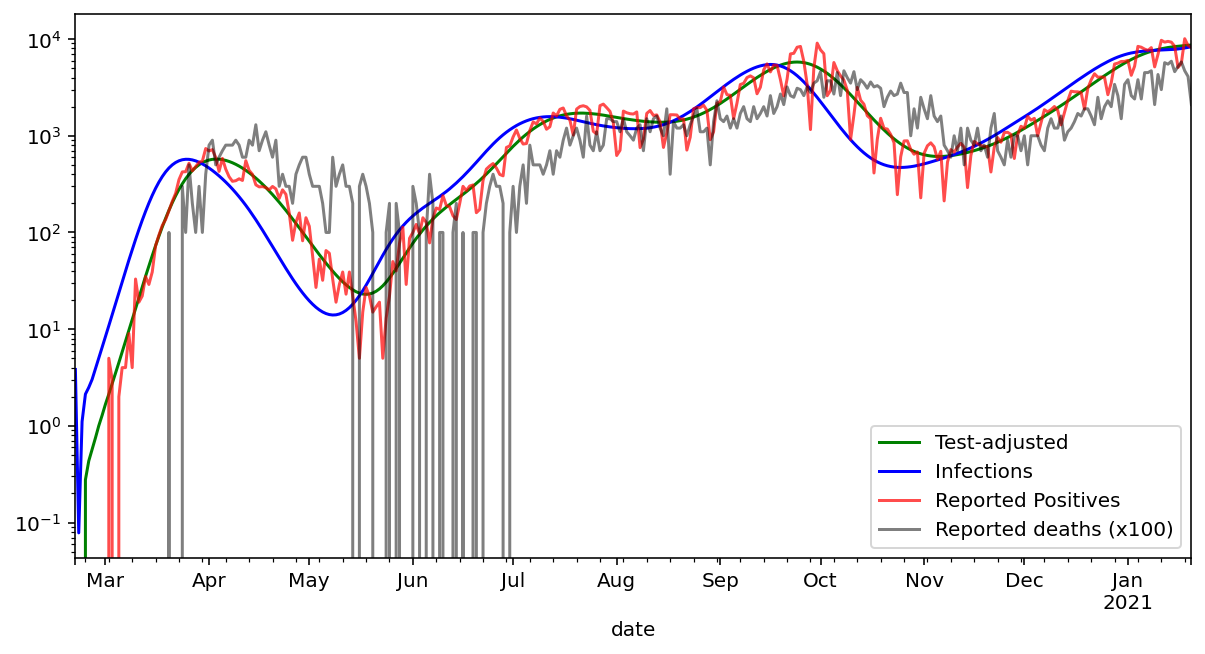

In [11]:
fig, ax = plt.subplots(figsize=(10,5))
resultunn.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultunn.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultunn.infections.plot(c="b", label="Infections")
gmunn.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
d = gmunn.observed.deaths * 100
d.plot(c='k', alpha=0.5, label="Reported deaths (x100)")
plt.yscale("log")
fig.set_facecolor('w')
ax.legend();

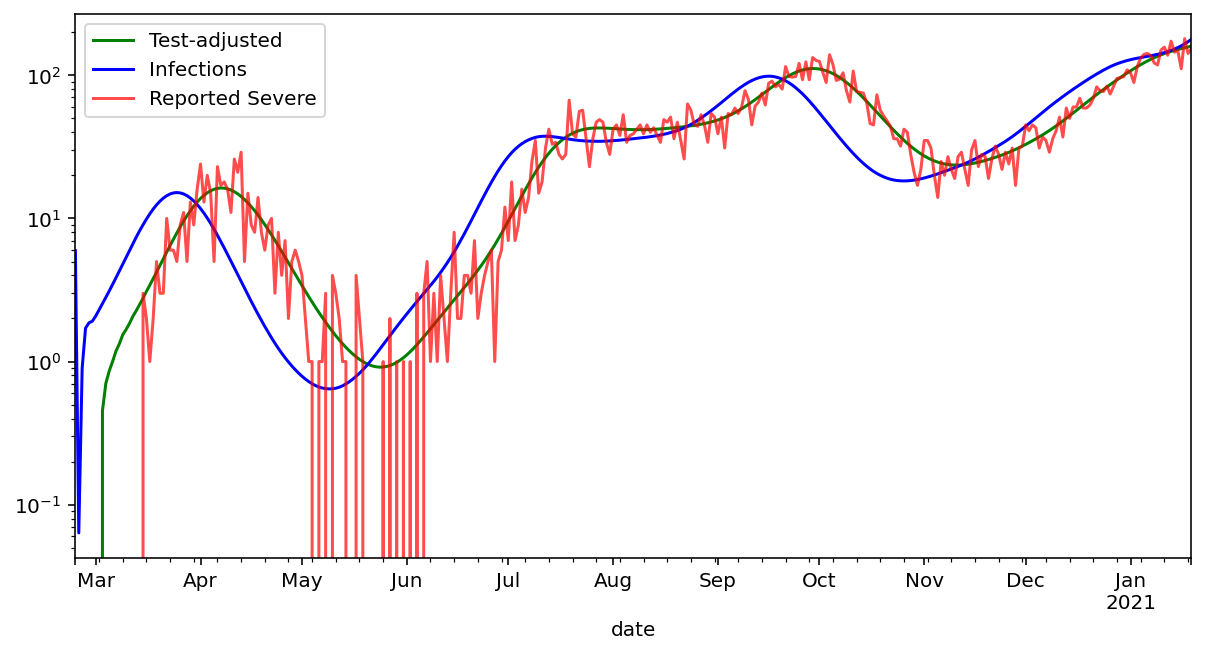

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
resultsev.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultsev.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultsev.infections.plot(c="b", label="Infections")
gmsev.observed.positive.plot(c='r', alpha=.7, label="Reported Severe")
fig.set_facecolor('w')
plt.yscale("log")
ax.legend();

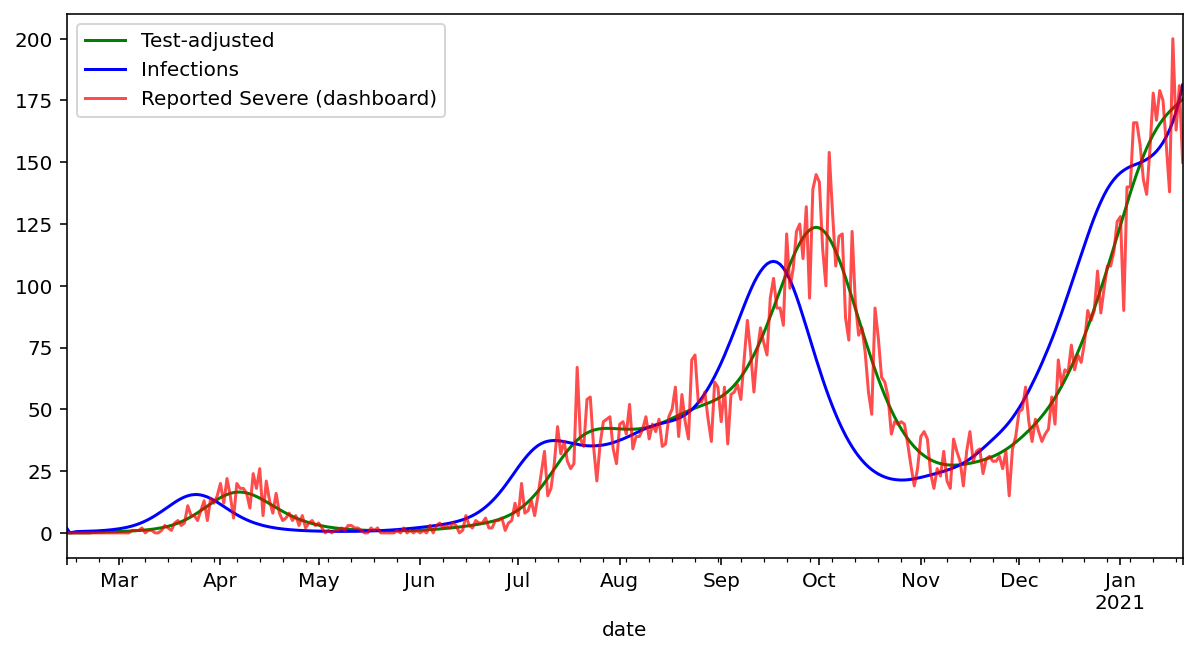

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
resultsevdash.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultsev.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultsevdash.infections.plot(c="b", label="Infections")
gmsevdash.observed.positive.plot(c='r', alpha=.7, label="Reported Severe (dashboard)")
fig.set_facecolor('w')
ax.legend();

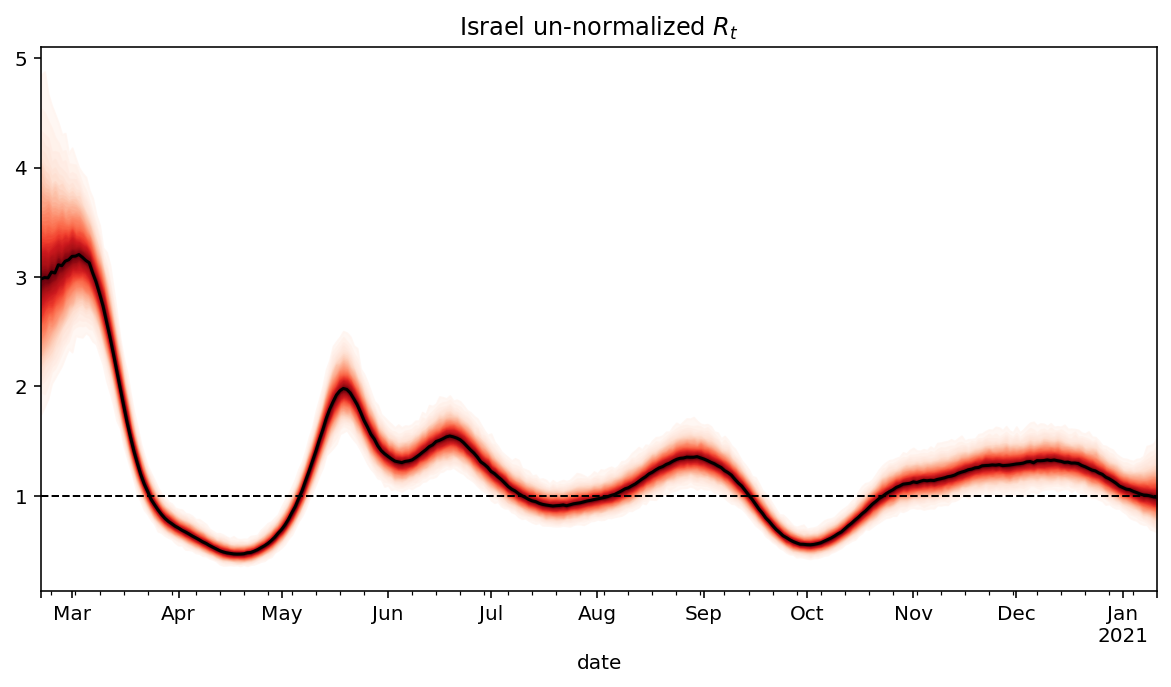

In [14]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} un-normalized $R_t$")
samples = gmunn.trace['r_t']
x=resultunn.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultunn["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
#ax.set_xlim(left = pd.Timestamp.today()-pd.Timedelta(days=70), right=pd.Timestamp.today()-pd.Timedelta(days=10))
#ax.set_ylim(top = 2)
fig.set_facecolor('w')
fig.savefig("Israel_unnorm_Rt_est.svg")

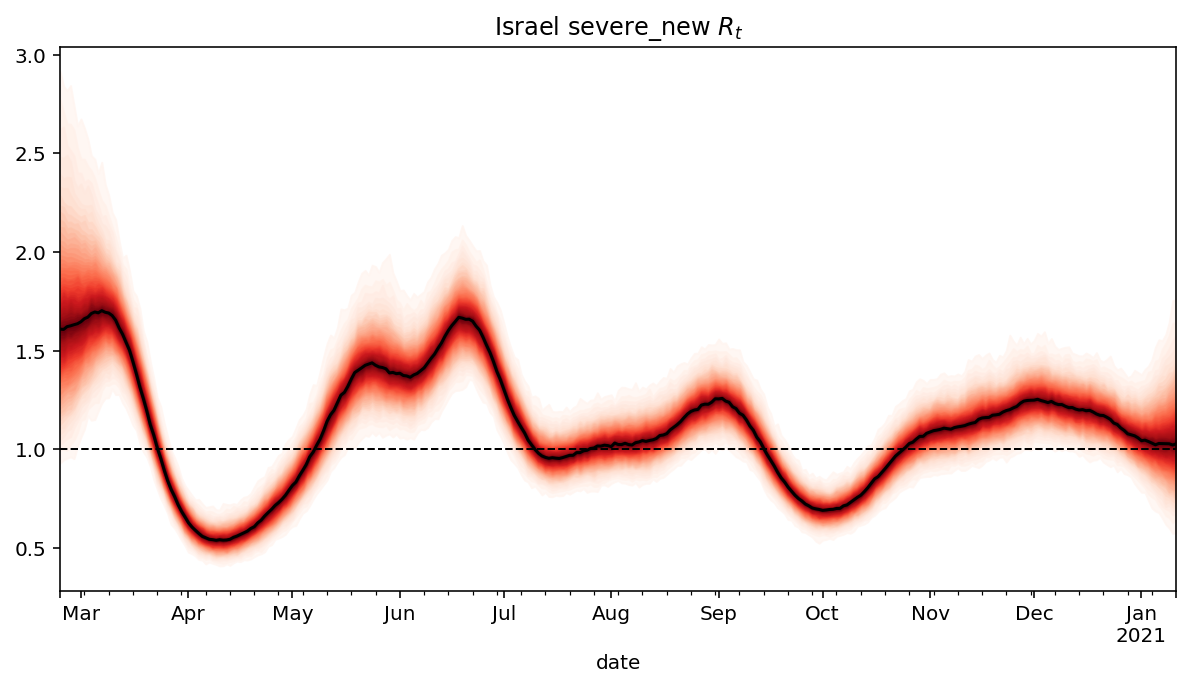

In [15]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} severe_new $R_t$")
samples = gmsev.trace['r_t']
x=resultsev.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultsev["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')

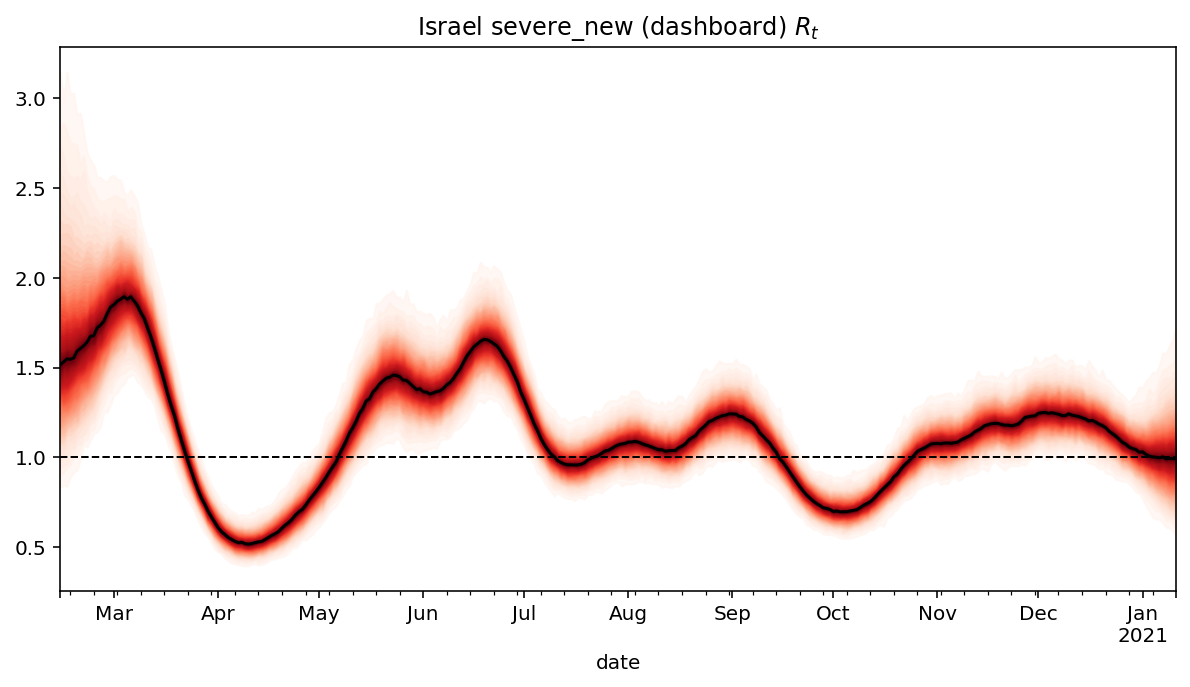

In [16]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} severe_new (dashboard) $R_t$")
samples = gmsevdash.trace['r_t']
x=resultsevdash.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultsevdash["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')

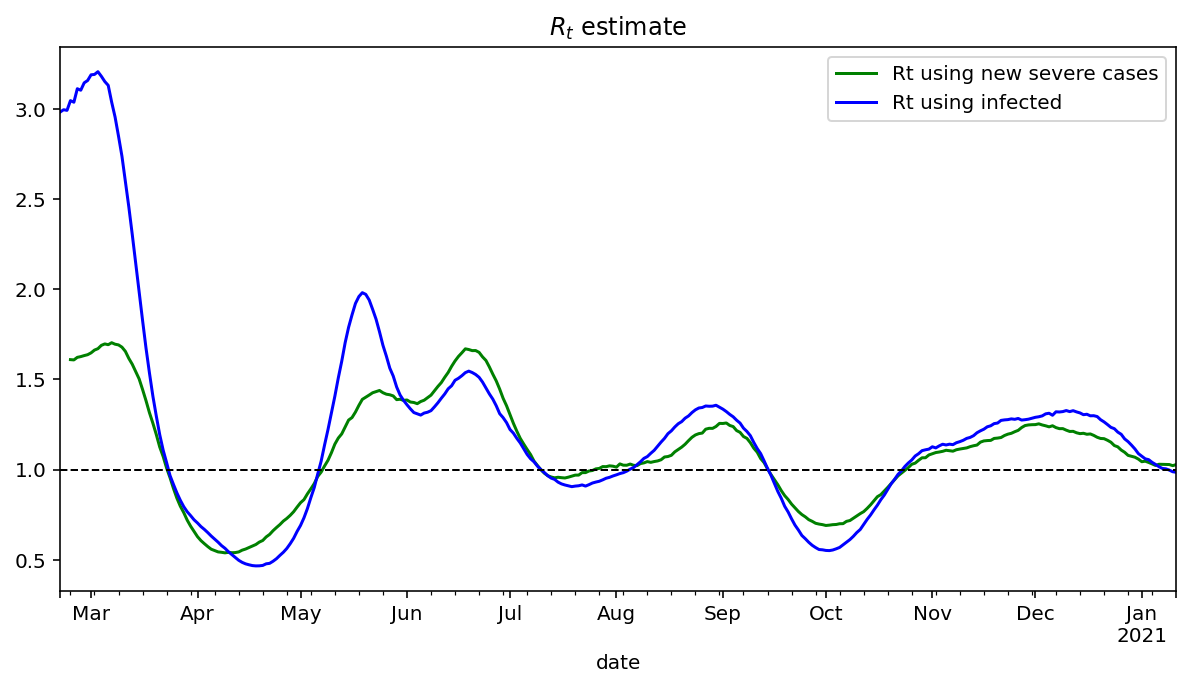

In [17]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title(f"$R_t$ estimate")
resultsev["median"].plot(c="g", ls='-', label="Rt using new severe cases")
#resultsevdash["median"].plot(c="r", ls='-', label="Rt using new severe cases from dashboard")
resultunn["median"].plot(c="b", ls='-', label="Rt using infected")
ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
ax.legend()

In [18]:
resultunn.to_csv("results_unnormalized_out.csv")

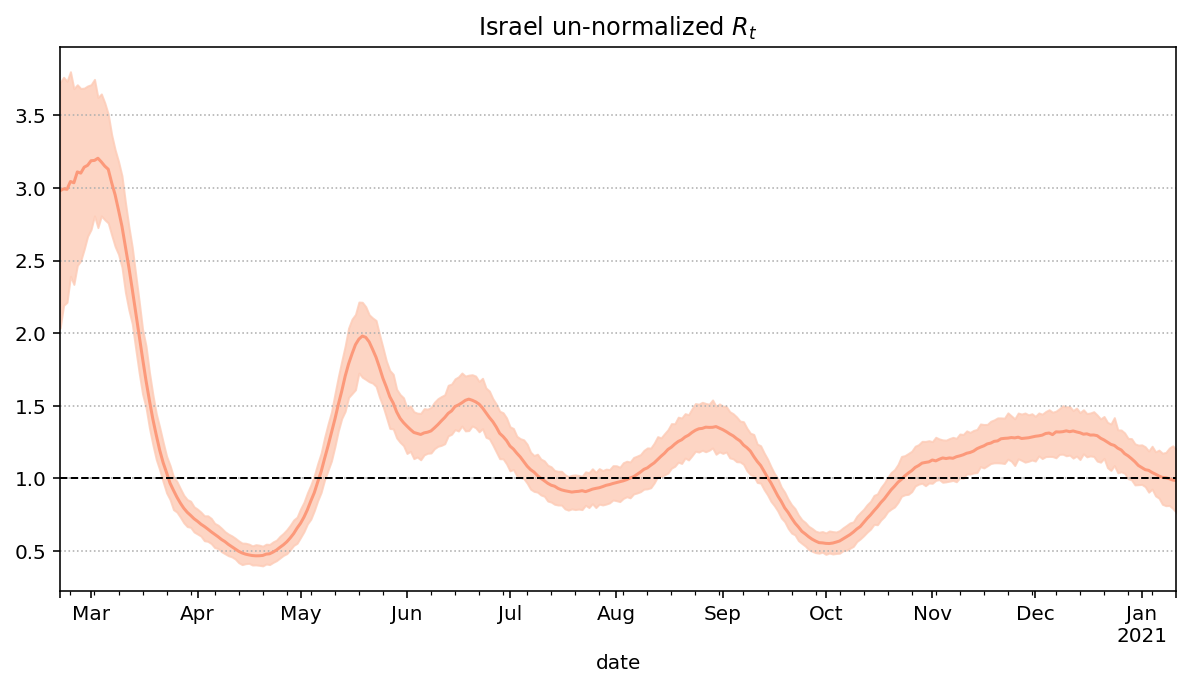

In [19]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} un-normalized $R_t$")
samples = gmunn.trace['r_t']
x=resultunn.index
cmap = plt.get_cmap("Reds")
ax.fill_between(x, resultunn["upper_80"], resultunn["lower_80"], color=cmap(50), alpha=.8)
resultunn["median"].plot(c=cmap(90), ls='-', label="Rt using infected")
ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
#ax.set_xlim(left = pd.Timestamp.today()-pd.Timedelta(days=70), right=pd.Timestamp.today()-pd.Timedelta(days=10))
#ax.set_ylim(top = 2)
fig.set_facecolor('w')
plt.grid(which='major', axis='y', ls=':')
fig.savefig("Israel_unnorm_Rt_est.svg")